In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
import numpy as np
import matplotlib.pyplot as plt

# --- Configuration ---
BATCH_SIZE = 1 # Assignment asks for SGD (batch_size=1) for most parts [cite: 100]
CLASSES_TO_KEEP = [0, 1, 2, 3, 4] # We will use digits 0-4
INPUT_SIZE = 28 * 28 # 784
OUTPUT_SIZE = 5 # 5 classes

# --- 1. Load & Filter Data ---
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)) # Normalize to range [-1, 1]
])

print("Downloading MNIST...")
train_full = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_full = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Helper function to keep only specific digits
def filter_dataset(dataset, classes):
    indices = [i for i, label in enumerate(dataset.targets) if label in classes]
    return Subset(dataset, indices)

print(f"Filtering for classes {CLASSES_TO_KEEP}...")
train_subset = filter_dataset(train_full, CLASSES_TO_KEEP)
test_subset = filter_dataset(test_full, CLASSES_TO_KEEP)

# Create DataLoaders
# We create a default loader here, but we will make custom ones later for Batch GD
train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_subset, batch_size=1000, shuffle=False)

print(f"Data Ready. Training samples: {len(train_subset)}, Test samples: {len(test_subset)}")

100%|██████████| 9.91M/9.91M [00:00<00:00, 60.9MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.76MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 15.0MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.60MB/s]


Filtering for classes [0, 1, 2, 3, 4]...
Data Ready. Training samples: 30596, Test samples: 5139


In [2]:
# --- 2. Dynamic Neural Network Architecture ---
class FlexibleNN(nn.Module):
    def __init__(self, input_size, hidden_dims, output_size):
        super(FlexibleNN, self).__init__()
        layers = []

        # Input Layer -> First Hidden
        layers.append(nn.Linear(input_size, hidden_dims[0]))
        layers.append(nn.ReLU()) # ReLU is standard for hidden layers

        # Hidden -> Hidden (intermediate layers)
        for i in range(len(hidden_dims) - 1):
            layers.append(nn.Linear(hidden_dims[i], hidden_dims[i+1]))
            layers.append(nn.ReLU())

        # Last Hidden -> Output
        layers.append(nn.Linear(hidden_dims[-1], output_size))

        # Combine all layers into a sequential model
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(x.shape[0], -1) # Flatten image (N, 28*28)
        return self.network(x)

# --- 3. Optimizer Factory ---
def get_optimizer(model, opt_name, lr=0.001):
    # Returns the correct PyTorch optimizer based on the name
    # Parameters are strictly taken from the Assignment PDF [cite: 109-112]

    if opt_name == "SGD":
        # Standard Stochastic Gradient Descent
        return optim.SGD(model.parameters(), lr=lr)

    elif opt_name == "Batch GD":
        # Same as SGD, but we will handle the "Batch" part in the training loop
        return optim.SGD(model.parameters(), lr=lr)

    elif opt_name == "Momentum":
        # SGD with Momentum (gamma=0.9)
        return optim.SGD(model.parameters(), lr=lr, momentum=0.9)

    elif opt_name == "NAG":
        # Nesterov Accelerated Gradient (momentum=0.9, nesterov=True)
        return optim.SGD(model.parameters(), lr=lr, momentum=0.9, nesterov=True)

    elif opt_name == "RMSprop":
        # RMSprop (alpha=0.99, eps=1e-8)
        return optim.RMSprop(model.parameters(), lr=lr, alpha=0.99, eps=1e-8)

    elif opt_name == "Adam":
        # Adam (beta1=0.9, beta2=0.999, eps=1e-8)
        return optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.999), eps=1e-8)

    return None

In [3]:
# --- FAST VERSION: Overwrite Data Loading ---

# We take the existing full subset and slice it down
# From ~30,000 images -> 1,000 images
# From ~5,000 test images -> 500 test images

indices = np.arange(1000) # Only first 1000
train_subset_small = Subset(train_subset, indices)

test_indices = np.arange(500)
test_subset_small = Subset(test_subset, test_indices)

# Re-create DataLoaders with the small dataset
# Note: We keep batch_size=1 to satisfy the assignment rule,
# but now the loop is short.
train_loader_fast = DataLoader(train_subset_small, batch_size=1, shuffle=True)
test_loader_fast = DataLoader(test_subset_small, batch_size=1000, shuffle=False)

# Special Loader for Batch GD (uses all 1000 images at once)
batch_gd_loader_fast = DataLoader(train_subset_small, batch_size=len(train_subset_small), shuffle=True)

print(f"FAST MODE ACTIVATED.")
print(f"Training on {len(train_subset_small)} samples (instead of 30,000).")
print("This should take ~10 seconds per experiment instead of 5 minutes.")

FAST MODE ACTIVATED.
Training on 1000 samples (instead of 30,000).
This should take ~10 seconds per experiment instead of 5 minutes.


Starting Training (Running 18 Experiments)...

Training Architecture: 3_Layers ...

Training Architecture: 4_Layers ...

Training Architecture: 5_Layers ...

All experiments completed in 903.42 seconds.

Generating Plots...


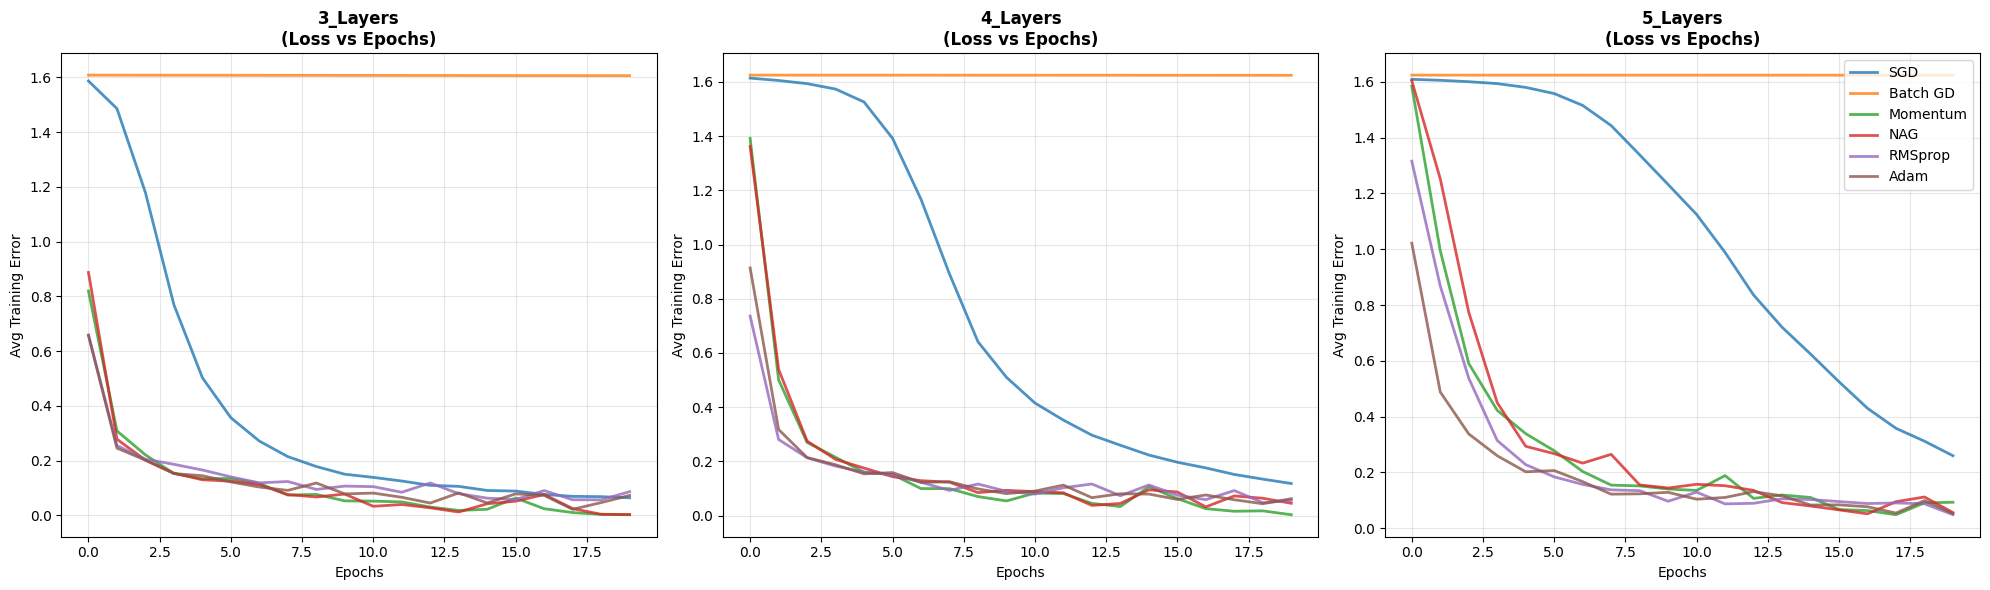


   CONVERGENCE COMPARISON TABLE
Architecture 3_Layers 4_Layers 5_Layers
Optimizer                              
SGD               >20      >20      >20
Batch GD          >20        2        2
Momentum          >20      >20      >20
NAG               >20      >20      >20
RMSprop           >20      >20      >20
Adam              >20      >20      >20

(Note: '>20' indicates the stopping threshold 10e-4 was not reached in 20 epochs)


In [4]:
import matplotlib.pyplot as plt
import pandas as pd
import torch.nn as nn
import time

# --- 1. Helper: Training Loop ---
def train_network(model, optimizer, loader, criterion, epochs):
    loss_history = []
    model.train()

    for epoch in range(epochs):
        epoch_loss = 0.0
        count = 0

        for inputs, labels in loader:
            # Zero gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass & Optimize
            loss.backward()
            optimizer.step()

            # Accumulate loss (sum of errors)
            epoch_loss += loss.item() * inputs.size(0)
            count += inputs.size(0)

        # Average loss for the epoch
        avg_loss = epoch_loss / count
        loss_history.append(avg_loss)

        # Optional: Print progress every 5 epochs
        # if (epoch + 1) % 5 == 0:
        #     print(f"    Epoch {epoch+1}/{epochs} | Loss: {avg_loss:.4f}")

    return loss_history

# --- 2. Configuration ---
# Define the 3 architectures (Hidden Layers only)
# Input (784) and Output (5) are handled automatically by the class
architectures = {
    "3_Layers": [128, 64, 32],             # Shallow
    "4_Layers": [128, 64, 32, 16],         # Medium
    "5_Layers": [128, 64, 32, 16, 8]       # Deep
}

opt_names = ["SGD", "Batch GD", "Momentum", "NAG", "RMSprop", "Adam"]
MAX_EPOCHS = 20  # Sufficient for fast convergence on this subset

# Storage for plotting and table
history = {arch: {} for arch in architectures}
convergence_table = []

print("Starting Training (Running 18 Experiments)...")
start_time = time.time()

# --- 3. Main Experiment Loop ---
for arch_name, hidden_dims in architectures.items():
    print(f"\nTraining Architecture: {arch_name} ...")

    for opt_name in opt_names:
        # A. Initialize Model & Optimizer
        model = FlexibleNN(INPUT_SIZE, hidden_dims, OUTPUT_SIZE)
        optimizer = get_optimizer(model, opt_name)
        criterion = nn.CrossEntropyLoss()

        # B. Select Correct Loader
        # Batch GD needs the loader that yields ALL data in 1 step
        if opt_name == "Batch GD":
            current_loader = batch_gd_loader_fast
        else:
            current_loader = train_loader_fast # Standard SGD loader (batch=1)

        # C. Train
        losses = train_network(model, optimizer, current_loader, criterion, MAX_EPOCHS)
        history[arch_name][opt_name] = losses

        # D. Calculate Convergence (First epoch where diff < 1e-4)
        converged_epoch = ">20" # Default
        for i in range(1, len(losses)):
            if abs(losses[i] - losses[i-1]) < 1e-4:
                converged_epoch = i + 1
                break

        # E. Store stats for the table
        convergence_table.append({
            "Architecture": arch_name,
            "Optimizer": opt_name,
            "Converged (Epoch)": converged_epoch,
            "Final Loss": f"{losses[-1]:.4f}"
        })

total_time = time.time() - start_time
print(f"\nAll experiments completed in {total_time:.2f} seconds.")

# --- 4. Visualization (Superimposed Plots) ---
print("\nGenerating Plots...")
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown']

# Iterate through architectures to create 3 plots
for i, (arch_name, results) in enumerate(history.items()):
    ax = axes[i]

    # Plot all 6 optimizers on this single graph
    for j, (opt_name, loss_curve) in enumerate(results.items()):
        ax.plot(loss_curve, label=opt_name, color=colors[j], linewidth=2, alpha=0.8)

    ax.set_title(f"{arch_name}\n(Loss vs Epochs)", fontweight='bold', fontsize=12)
    ax.set_xlabel("Epochs")
    ax.set_ylabel("Avg Training Error")
    ax.grid(True, alpha=0.3)

    # Only put legend on the first plot to avoid clutter, or last if preferred
    if i == 2:
        ax.legend(loc='upper right')

plt.tight_layout()
plt.show()

# --- 5. Print Convergence Table ---
print("\n" + "="*40)
print("   CONVERGENCE COMPARISON TABLE")
print("="*40)
df_results = pd.DataFrame(convergence_table)

# Pivot for a clean report-ready view
# Rows: Optimizers, Columns: Architectures, Values: Epochs to Converge
pivot_df = df_results.pivot(index="Optimizer", columns="Architecture", values="Converged (Epoch)")

# Reorder index to match our logical order
pivot_df = pivot_df.reindex(opt_names)

print(pivot_df)
print("\n(Note: '>20' indicates the stopping threshold 10e-4 was not reached in 20 epochs)")

In [5]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix
import torch
import time

# --- Helper: Calculate Accuracy ---
def get_accuracy(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

# --- Helper: Get Predictions for Confusion Matrix ---
def get_all_preds(model, loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return all_labels, all_preds

# --- Configuration ---
architectures = {
    "3_Layers": [128, 64, 32],
    "4_Layers": [128, 64, 32, 16],
    "5_Layers": [128, 64, 32, 16, 8]
}
opt_names = ["SGD", "Batch GD", "Momentum", "NAG", "RMSprop", "Adam"]
MAX_EPOCHS = 20

# Store full results for final selection
full_results = []
best_val_acc = 0.0
best_config = None # Will store (Arch, Opt) of the winner

print(f"Starting Grid Search (18 Experiments)...")
start_time = time.time()

# --- Main Loop ---
for arch_name, hidden_dims in architectures.items():
    print(f"\n--- Processing {arch_name} ---")

    for opt_name in opt_names:
        # 1. Initialize
        model = FlexibleNN(INPUT_SIZE, hidden_dims, OUTPUT_SIZE)
        optimizer = get_optimizer(model, opt_name)
        criterion = nn.CrossEntropyLoss()

        # Select Loader
        if opt_name == "Batch GD":
            train_loader_use = batch_gd_loader_fast
        else:
            train_loader_use = train_loader_fast

        # 2. Train (We reuse the function from previous cells, simplified here)
        model.train()
        for epoch in range(MAX_EPOCHS):
            for inputs, labels in train_loader_use:
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

        # 3. Calculate Accuracies
        train_acc = get_accuracy(model, train_loader_use)
        val_acc = get_accuracy(model, test_loader_fast) # Using Test set as Validation

        # 4. Check if this is the best model so far
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_config = {
                "Architecture": arch_name,
                "Optimizer": opt_name,
                "Model_State": model.state_dict(), # Save weights
                "Hidden_Dims": hidden_dims
            }

        # 5. Store Stats
        full_results.append({
            "Architecture": arch_name,
            "Optimizer": opt_name,
            "Train Accuracy": train_acc,
            "Val Accuracy": val_acc
        })
        print(f"   {opt_name}: Train={train_acc:.1f}%, Val={val_acc:.1f}%")

total_time = time.time() - start_time
print(f"\nCompleted in {total_time:.2f}s")

# --- Display Results Table ---
results_df = pd.DataFrame(full_results)
print("\n=== Accuracy Comparison Table ===")
# Pivot for clean viewing
pivot_table = results_df.pivot(index="Optimizer", columns="Architecture", values="Val Accuracy")
print(pivot_table)

Starting Grid Search (18 Experiments)...

--- Processing 3_Layers ---
   SGD: Train=99.5%, Val=96.0%
   Batch GD: Train=18.5%, Val=19.6%
   Momentum: Train=99.9%, Val=97.6%
   NAG: Train=98.4%, Val=93.0%
   RMSprop: Train=97.6%, Val=95.4%
   Adam: Train=98.5%, Val=93.4%

--- Processing 4_Layers ---
   SGD: Train=96.9%, Val=94.8%
   Batch GD: Train=15.7%, Val=18.0%
   Momentum: Train=99.8%, Val=96.2%
   NAG: Train=97.4%, Val=92.4%
   RMSprop: Train=95.0%, Val=91.4%
   Adam: Train=99.1%, Val=95.2%

--- Processing 5_Layers ---
   SGD: Train=94.7%, Val=91.6%
   Batch GD: Train=21.8%, Val=22.8%
   Momentum: Train=99.7%, Val=96.8%
   NAG: Train=95.8%, Val=91.0%
   RMSprop: Train=99.6%, Val=96.4%
   Adam: Train=99.4%, Val=95.8%

Completed in 911.98s

=== Accuracy Comparison Table ===
Architecture  3_Layers  4_Layers  5_Layers
Optimizer                                 
Adam              93.4      95.2      95.8
Batch GD          19.6      18.0      22.8
Momentum          97.6      96.2      96


=== BEST MODEL SELECTED: 3_Layers + Momentum ===
Validation Accuracy: 97.60%


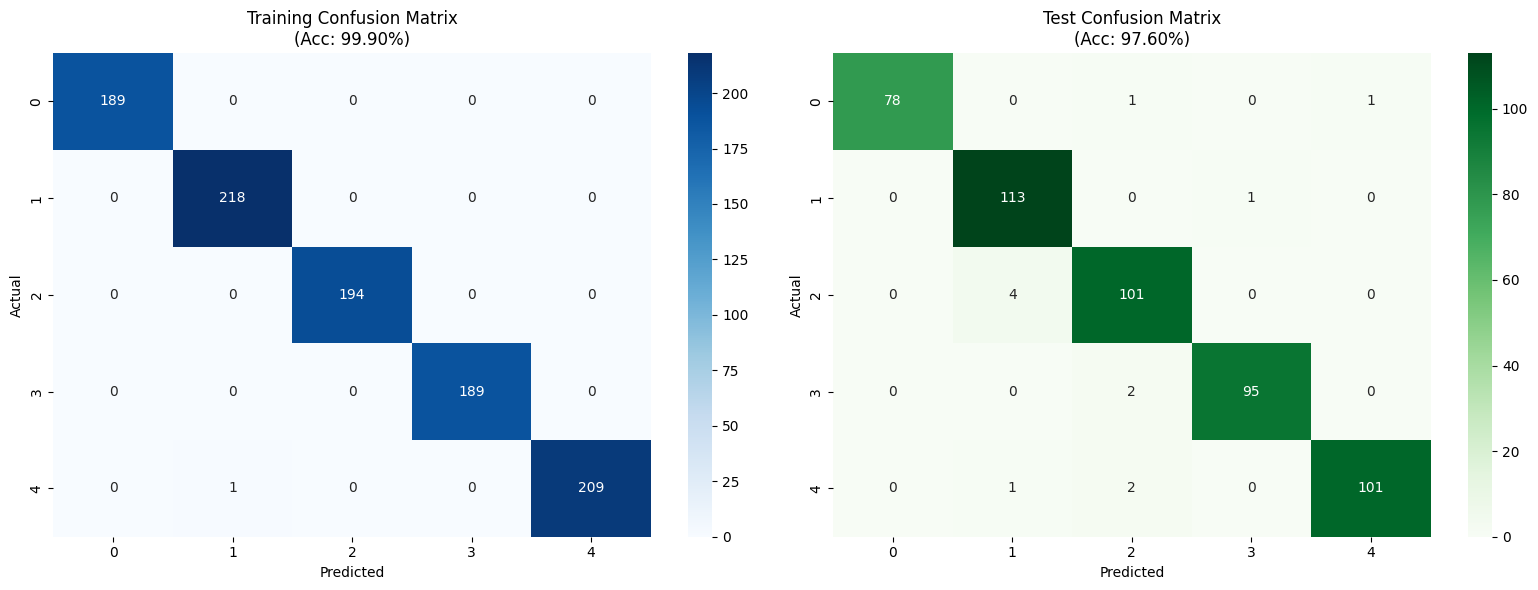


--- Final Performance Report ---
Best Architecture: 3_Layers
Best Optimizer:    Momentum
Training Accuracy: 99.90%
Test Accuracy:     97.60%


In [6]:
# --- 1. Load the Best Model ---
print(f"\n=== BEST MODEL SELECTED: {best_config['Architecture']} + {best_config['Optimizer']} ===")
print(f"Validation Accuracy: {best_val_acc:.2f}%")

# Re-create the model structure
final_model = FlexibleNN(INPUT_SIZE, best_config['Hidden_Dims'], OUTPUT_SIZE)
# Load the trained weights we saved
final_model.load_state_dict(best_config['Model_State'])

# --- 2. Get Predictions ---
# We need both Training and Test predictions for the report
y_true_train, y_pred_train = get_all_preds(final_model, train_loader_fast)
y_true_test, y_pred_test = get_all_preds(final_model, test_loader_fast)

# --- 3. Plot Confusion Matrices ---
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot A: Training Matrix
cm_train = confusion_matrix(y_true_train, y_pred_train)
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title(f"Training Confusion Matrix\n(Acc: {get_accuracy(final_model, train_loader_fast):.2f}%)")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")

# Plot B: Test Matrix
cm_test = confusion_matrix(y_true_test, y_pred_test)
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Greens', ax=axes[1])
axes[1].set_title(f"Test Confusion Matrix\n(Acc: {best_val_acc:.2f}%)")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Actual")

plt.tight_layout()
plt.show()

# --- 4. Final Text Report ---
print("\n--- Final Performance Report ---")
print(f"Best Architecture: {best_config['Architecture']}")
print(f"Best Optimizer:    {best_config['Optimizer']}")
print(f"Training Accuracy: {get_accuracy(final_model, train_loader_fast):.2f}%")
print(f"Test Accuracy:     {best_val_acc:.2f}%")